### Reading MNIST

In [1]:
import pandas as pd
import numpy as np


train = pd.read_csv("../data/mnist_train.csv")
test = pd.read_csv("../data/mnist_test.csv")

# Reestructuring
train_label, train_image = train["label"].to_numpy(), train[[x for x in train.columns if x != "label"]].to_numpy().reshape((-1, 1, 28, 28))/255
test_label, test_image = train["label"].to_numpy(), train[[x for x in train.columns if x != "label"]].to_numpy().reshape((-1, 1, 28, 28))/255

# One-hotting
one_hot = np.zeros((len(train_label), 10))
for label in range(train_label.shape[0]):
    one_hot[label, train_label[label]] = 1
train_label = one_hot

one_hot = np.zeros((len(test_label), 10))
for label in range(test_label.shape[0]):
    one_hot[label, test_label[label]] = 1
test_label = one_hot

### Creating The Model

In [7]:
import framework as fm

class Model(fm.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = fm.Conv2d(1, 6, 5, 1, bias = False)
        self.relu1 = fm.ReLu()
        self.maxpool1 = fm.MaxPool2d(2, 6, 2)

        self.conv2 = fm.Conv2d(6, 16, 5, 1, bias = False)
        self.maxpool2 = fm.MaxPool2d(2, 16, 2)
        self.bn1 = fm.BatchNorm(1)
        self.lin1 = fm.Linear(256, 84, bias=False)
        self.bn2 = fm.BatchNorm(1)
        self.drop2 = fm.Dropout(0.2)
        self.lin2 = fm.Linear(84, 10, bias=False)


    def forward(self, x):
        x = self.conv1.forward(x) 
        x = self.relu1.forward(x) 
        x = self.maxpool1.forward(x)
        x = self.conv2.forward(x)
        x = self.maxpool2.forward(x)
        x = x.reshape((-1, 256))
        x = self.bn1.forward(x)
        x = self.lin1.forward(x) 
        x = self.bn2.forward(x)
        x = self.drop2.forward(x)
        x = self.lin2.forward(x)
        return x

model = Model()
model.train()
loss_fn = fm.CrossEntropy()
optim = fm.Adadelta(model.get_parameters())


#### Training The Model

In [4]:
def train(model, x, y, batch_size, loss_fn, optim):

    num_batches = int(len(y)/batch_size)

    total_loss = 0
    total_correct = 0

    for batch in range(num_batches):
        batch_start, batch_end = (batch * batch_size, (batch + 1) * batch_size)

        inpt = fm.Tensor(x[batch_start:batch_end])
        label = fm.Tensor(y[batch_start:batch_end])
        
        pred = model.forward(inpt)
    
        pred_nums = np.argmax(pred.data, axis=1)
        label_nums = np.argmax(label.data, axis=1)

        correct = (pred_nums == label_nums).sum()
        
        loss = loss_fn.forward(pred, label)

        total_loss += loss 
        total_correct += correct

        if batch % int(num_batches/10) == 0:
            print(f"loss: {loss} [{(batch+1)*batch_size}/{batch_size*num_batches}]")   
      
        loss_fn.backward()
        optim.step()

    total_loss /= num_batches
    total_correct /= num_batches * batch_size

    print("Avg error: ", total_loss)
    print("Train Precision: ", total_correct, "\n")  

    return total_loss, total_correct


In [5]:
def test(model, x, y, batch_size):
    model.test()
    correct = 0
    batch_size = 128
    num_batches = int(len(y)/batch_size)
    for batch in range(num_batches):
            batch_start, batch_end = (batch * batch_size, (batch + 1) * batch_size)

            inpt = fm.Tensor(x[batch_start:batch_end])
            label = fm.Tensor(y[batch_start:batch_end])
            
            pred = model.forward(inpt)

            pred_nums = np.argmax(pred.data, axis=1)
            label_nums = np.argmax(label.data, axis=1)

            correct += (pred_nums == label_nums).sum()

    correct /= batch_size * num_batches

    print("Test Accuracy:", correct * 100, "%\n")
    return correct

In [8]:
import matplotlib.pyplot as plt

losses = []
train_precision = []

test_precision = []

epochs = 50

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    model.train()

    loss, precision = train(model, train_image, train_label, 128, loss_fn, optim)
    
    losses.append(loss)
    train_precision.append(precision)

    if epoch % 2 == 0:
        model.test()
        precision = test(model, test_image, test_label, 128)

        test_precision.append(precision)


Epoch 1
-------------------------------
loss: 2.869347095489502 [128/59904]
loss: 0.597331166267395 [6016/59904]
loss: 0.6749674081802368 [11904/59904]
loss: 0.5430814623832703 [17792/59904]
loss: 0.43444833159446716 [23680/59904]
loss: 0.31527289748191833 [29568/59904]
loss: 0.2771932780742645 [35456/59904]
loss: 0.4674035310745239 [41344/59904]
loss: 0.21692675352096558 [47232/59904]
loss: 0.23428824543952942 [53120/59904]
loss: 0.05379745364189148 [59008/59904]
Avg error:  0.45816857
Train Precision:  0.8544170673076923 

Test Accuracy: 92.56810897435898 %

Epoch 2
-------------------------------
loss: 0.2368735671043396 [128/59904]
loss: 0.1783764660358429 [6016/59904]
loss: 0.25972092151641846 [11904/59904]
loss: 0.27584555745124817 [17792/59904]
loss: 0.22613418102264404 [23680/59904]
loss: 0.13181421160697937 [29568/59904]
loss: 0.10659414529800415 [35456/59904]
loss: 0.29942119121551514 [41344/59904]
loss: 0.11493083834648132 [47232/59904]
loss: 0.1422429084777832 [53120/59904]

KeyboardInterrupt: 

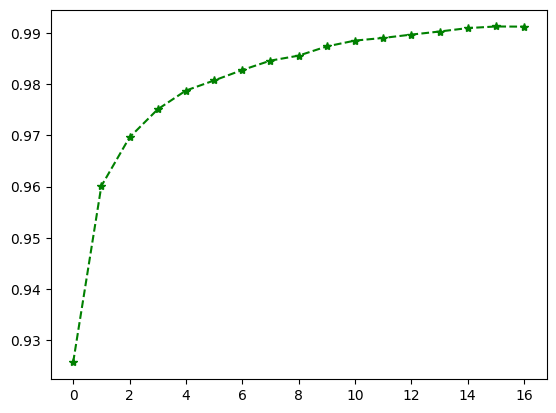

In [14]:
plt.plot(np.arange(0, len(test_precision)), test_precision, "g*--")

plt.show()

### Saving model

In [9]:
model.save("99_12precision")

Object saved successfully.


### Load Model

In [ ]:
import pickle
import framework as fm 
import numpy as np 
import pandas as np

with open('97precision.pkl', 'rb') as file:
    model = pickle.load(file)

print("Object loaded successfully.")

Object loaded successfully.


#### Test Accuracy

In [15]:
# Testing
model.test()
correct = 0
batch_size = 128
num_batches = int(len(train_label)/batch_size)
for batch in range(num_batches):
        batch_start, batch_end = (batch * batch_size, (batch + 1) * batch_size)

        inpt = fm.Tensor(test_image[batch_start:batch_end])
        label = fm.Tensor(test_label[batch_start:batch_end])
        
        pred = model.forward(inpt)

        pred_nums = np.argmax(pred.data, axis=1)
        label_nums = np.argmax(label.data, axis=1)

        correct += (pred_nums == label_nums).sum()

print("Accuracy:", correct / (batch_size * num_batches) * 100, "%")

Accuracy: 99.24712873931624 %


#### Creation of API

In [ ]:
import uvicorn
from fastapi import Request, FastAPI
from fastapi.middleware.cors import CORSMiddleware
import nest_asyncio

app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

@app.post("/predict")
async def predict(request: Request):
    res = await request.json()
    picture = fm.Tensor(np.array(res).reshape((1, 1, 28, 28)))
    pred = model.forward(picture)
    num = int(np.argmax(pred.data, axis=1))

    return num

if __name__ == "__main__":
    
    nest_asyncio.apply()  # Allow asyncio.run to work in a running loop
    uvicorn.run(app, host="127.0.0.1", port=3838)

INFO:     Started server process [2663]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:3838 (Press CTRL+C to quit)


INFO:     127.0.0.1:48198 - "POST /predict HTTP/1.1" 500 Internal Server Error


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/home/eric/miniforge3/lib/python3.12/site-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/eric/miniforge3/lib/python3.12/site-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/eric/miniforge3/lib/python3.12/site-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/home/eric/miniforge3/lib/python3.12/site-packages/starlette/applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/home/eric/miniforge3/lib/python3.12/site-packages/starlette/middleware/errors.py", line 187, in __call__
    raise exc
  File "/home/eric/minifo

In [27]:
import numpy as np
import framework as fm

np.random.seed(0)
data = fm.Tensor(np.random.random((1, 10)))
drop = fm.Dropout(0.2)
drop.training = True

res = drop.forward(data)

loss = fm.Tensor(np.ones((data.data.shape)))

print("Data: ", data)

print(drop.mask)

print("Res: ", res)

res.backward(loss)

print("Data Loss: ", data.gradient)

Data:  [[0.5488135  0.71518934 0.60276335 0.5448832  0.4236548  0.6458941
  0.4375872  0.891773   0.96366274 0.3834415 ]]
[[0. 0. 0. 1. 0. 0. 0. 1. 0. 1.]]
Res:  [[0.        0.        0.        0.5448832 0.        0.        0.
  0.891773  0.        0.3834415]]
Data Loss:  [[0. 0. 0. 1. 0. 0. 0. 1. 0. 1.]]


In [1]:
%%time

import numpy as np
import framework as fm

np.random.seed(0)

conv = fm.Conv2dC(1, 100, 3, 1, bias = False)
x = np.random.random((100, 1, 28, 28))
res = conv.forward(fm.Tensor(x))

count = sum(res.data == 0)
count

CPU times: user 272 ms, sys: 32.4 ms, total: 304 ms
Wall time: 105 ms


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 